(90, 180)

This netcdf file contains records from 1880-01-15 00:00:00 to 2021-10-15 00:00:00


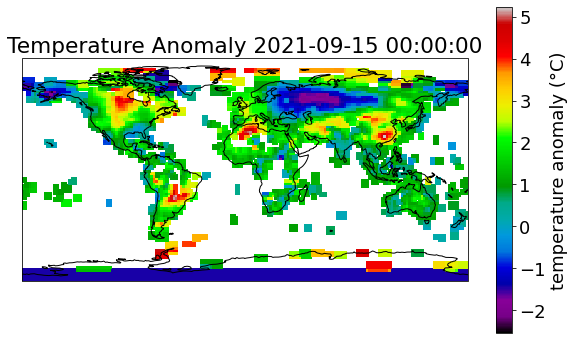

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
from netCDF4 import Dataset
from netCDF4 import date2index
from datetime import datetime
from datetime import timedelta
import scipy.optimize
from matplotlib import rcParams
from shapely.geometry import Point, Polygon
# Import cartopy - maybe more than I need
from cartopy import config
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np

# read netcdf file
data = Dataset('gistemp250_GHCNv4.nc')

# Get index for a certain month, read this month from the data below
year = 2021
month = 9
timeindex = date2index(datetime(year, month, 15),
                       data.variables['time'])




# read data 
# --------
###  complete the code here
###  read lat, lon, time and anomaly into numpy arrays
###  read tempanomaly for month defined above
###  replace fill values with np.nan

# solution
# --------
###  complete the code here
###  read lat, lon, time into numpy arrays
lat = data.variables['lat'][:].data
lon = data.variables['lon'][:].data
time = data.variables['time'][:].data

###  read tempanomaly (for month defined above) into numpy array
anom = data.variables['tempanomaly'][timeindex].data
anom_mask = data.variables['tempanomaly'][timeindex].mask

###  replace fill values
fillVal = data.variables['tempanomaly']._FillValue
anom[anom==fillVal] = np.nan

print(anom.shape)

# plot data 
# --------

# converting the 1D coordinate arrays to a meshgrid
lonGrid, latGrid = np.meshgrid(lon,lat)

# plot data into map
fig = plt.figure(figsize=(10, 6))

# plotting the first last map in the time series
ax = plt.axes(projection=ccrs.PlateCarree())

plt.pcolormesh(lonGrid,latGrid, anom, shading='auto',cmap='nipy_spectral') 
# try other colorbars: hot, hot_r, cool


# adding a colorbar and title
plt.title('Temperature Anomaly ' + str(datetime(year, month, 15)))
plt.colorbar(label=('temperature anomaly (' + u'\N{DEGREE SIGN}' + 'C)'))
ax.coastlines()
# add plot limits
#plt.clim(-8, 8)


# get available time period in netcdf file and write to screen
t_units = data.variables['time'].units
time_beg = netCDF4.num2date(data.variables['time'][0],t_units)
time_end = netCDF4.num2date(data.variables['time'][-1],t_units)
print('\nThis netcdf file contains records from ' + str(time_beg) +
      ' to ' + str(time_end))

In [22]:
# Initial information for bounding box
#lat_min = 22
#lat_max = 80
#lon_min = -126
#lon_max = -50

minLat = 28
maxLat = 52
minLon = -124
maxLon = -100
# Creating indexes of bounding conditions
where_minLat = np.argmin(np.abs(lat-lat_min))
where_maxLat = np.argmin(np.abs(lat-lat_max))
where_minLon = np.argmin(np.abs(lon-lon_min))
where_maxLon = np.argmin(np.abs(lon-lon_max))

fillVal = data.variables['tempanomaly']._FillValue

anomAll = data.variables['tempanomaly'][:].data
anomAll[anomAll==fillVal] = np.nan
anom_bound = anomAll[:,where_minLat:where_maxLat,where_minLon:where_maxLon].copy()

time = data.variables['time'][:].data
timeUnit = data.variables['time'].units

anom_bound.shape

(1702, 6, 6)

In [23]:
va_file = './boundary_UT.csv'
vaBound = np.genfromtxt(va_file, delimiter=',', skip_header=1)
tuple(vaBound[0,:]) # Ensure format of content

# Convert coordinate points stored in 2d array into lists
vaBoundList = []
for i in range(len(vaBound)):
    vaBoundList.append(tuple(vaBound[i,:]))
    

# Convert 2d lists into shapely class objects
vaPoly = Polygon(vaBoundList)

# Creating a mask 
vaMask = np.zeros(anom.shape) # Initiallize mask w/o data
## Must work over the 2 dimensions -- ensure nested loop covers lat + lon
for lo_l in range(len(lon)): # Iterate over the bounded lon range
    for la_l in range(len(lat)): # For each lon, iterate over the lats
        lo=lon[lo_l] # sets a numeric value to long
        la=lat[la_l] # sets a numeric value to lat
        point = Point(lo,la) # Convert numeric pair to shapley object
        check=point.within(vaPoly) # Boolean check of inclusion
        vaMask[la_l,lo_l] = int(check)
        
vaMask_nan = np.copy(vaMask)
vaMask_nan[vaMask_nan==0] = np.nan

lon1 = lat[where_minLat:where_maxLat]
lat1 = lon[where_minLon:where_maxLon]

lonGrid1, latGrid1 = np.meshgrid(lat1,lon1)

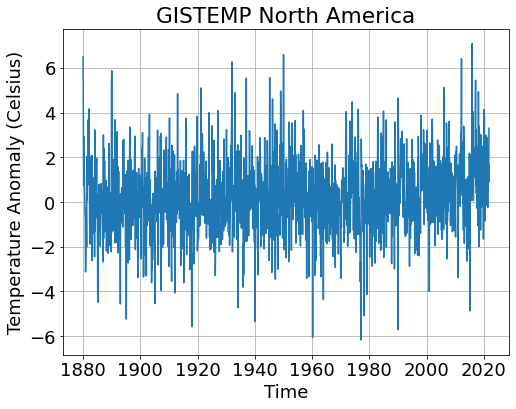

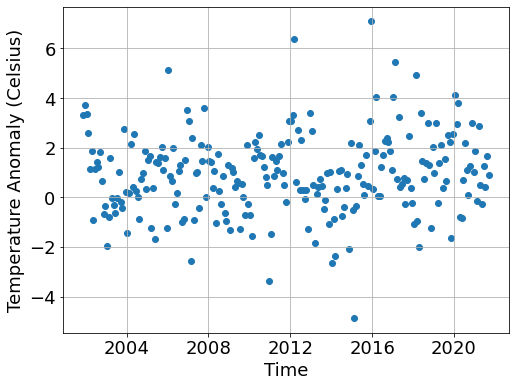

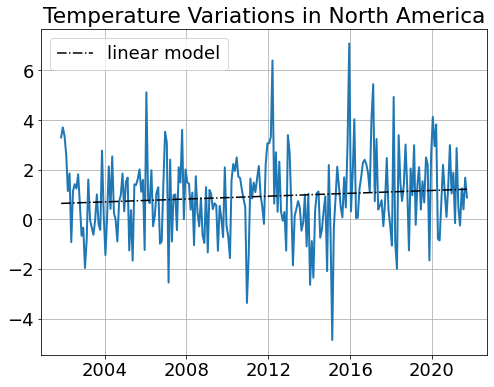

In [24]:
time_date = [ datetime(1800, 1, 1) + timedelta(float(date)) for date in time ]

# getting the number of months in the dataset (we know its 24)
NoOfMonths = len(time)    

# creating a numpy array of the same length, containing zeros
monthlyMeanAnom = np.zeros(NoOfMonths) 

# Estimating the global mean for each time step, by averaging over axis 1 and 2 in anomAll          
# using nanmean to make sure nan values are ignored
monthlyMeanAnom = np.nanmean(anomAll,axis = (1,2))
monthlyMeanAnom_bound =  np.nanmean(anom_bound,axis = (1,2))

# plotting the time series of mean 'tos' (over the entire globe)
plt.plot(time_date,monthlyMeanAnom_bound)

# adding labels
plt.title("GISTEMP North America")
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (Celsius)')
plt.grid()
plt.show()

# (set timeMin and timeMax accordingly)
timeMin = -12*20   # get records *(monthly) for last 20 years
timeMax = -1
time_short = time[timeMin:timeMax]
time_date_short = time_date[timeMin:timeMax]
monthlyMeanAnom_bound_short = monthlyMeanAnom_bound[timeMin:timeMax]
plt.scatter(time_date_short,monthlyMeanAnom_bound_short)
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (Celsius)')
plt.grid()
plt.show()

rcParams['figure.figsize'] = [8, 6]
rcParams.update({'font.size': 18})

# using only the short time series
t = time_short - time_short[0]
a1 = np.ones(len(t))
a2 = t
A = np.stack((a1,a2)).T
b = monthlyMeanAnom_bound_short
time_date_use = time_date_short

x = np.linalg.pinv(A)@b

# Estimating linear model output (b) for set of input points (a)
bf = x[0]  + x[1]* a2    #also:  b1 = np.polyval(xdag,a1)

# Plotting results for linear model
plt.figure()
plt.plot(time_date_use,b,linewidth=2)
plt.plot(time_date_use,bf,'-.',color='k',label="linear model")
plt.legend()
plt.title('Temperature Variations in North America')
plt.grid()
plt.show()


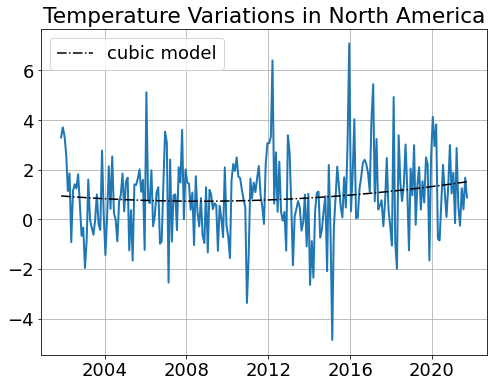

In [25]:
t = time_short - time_short[0]
a1 = np.ones(len(t))
a2 = t
a3 = np.square(t)
A = np.stack((a1,a2,a3)).T
b = monthlyMeanAnom_bound_short
time_date_use = time_date_short

x = np.linalg.pinv(A)@b

# Estimating linear model output (b) for set of input points (a)
bf = x[0]  + x[1]* a2  + x[2]* a3   #also:  b1 = np.polyval(xdag,a1)

# Plotting results for cubic model
plt.figure()
plt.plot(time_date_use,b,linewidth=2)
plt.plot(time_date_use,bf,'-.',color='k',label="cubic model")
plt.legend()
plt.title('Temperature Variations in North America')
plt.grid()
plt.show()

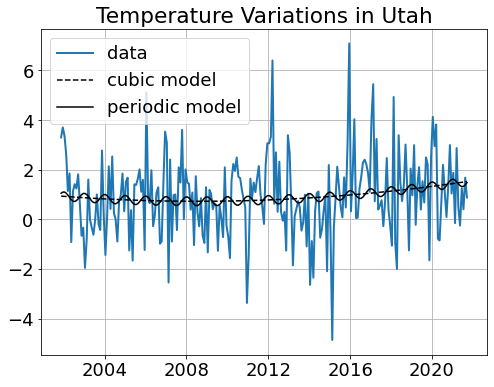

In [26]:
# Building the Equation System

# using only the short time series
t = time_short - time_short[0]
a1 = np.ones(len(t))
a2 = t
a3 = np.sin(t*2*np.pi/365)
a4 = np.cos(t*2*np.pi/365)
a5 = t*t
A = np.stack((a1,a2,a3,a4,a5)).T
b = monthlyMeanAnom_bound_short
time_date_use = time_date_short

x = np.linalg.pinv(A)@b

# Estimating linear model output (b) for set of input points (a)
bf = x[0]  + x[1]* t  + x[2] * np.sin(t*2*np.pi/365) +  x[3] * np.cos(t*2*np.pi/365)  + x[4]* t*t
bf2 = x[0]  + x[1]* t  + x[4]* t*t

# Plotting results for periodic model
plt.figure()
plt.plot(time_date_use,b,linewidth=2,label="data")
plt.plot(time_date_use,bf2,'--',color='k',label="cubic model")
plt.plot(time_date_use,bf,'-',color='k',label="periodic model")
plt.title('Temperature Variations in Utah')
plt.legend()
plt.grid()
plt.show()

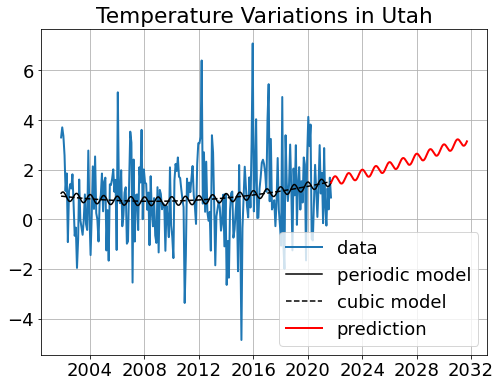

In [27]:
y = list(range(3649))
y2 = list(range(3649))
for i in range(len(y)):
    y[i] = 2.1

for i in range(len(y2)):
    y2[i] = 2.5


# Estimating linear model output (b) for set of input points (a)
t_future = t[-1] +  np.arange(1,365*10,1)  # added 10 years to time vector for prediction
bf_future = x[0]  + x[1]* t_future  + x[2] * np.sin(t_future*2*np.pi/365) +  x[3] * np.cos(t_future*2*np.pi/365) + x[4]* t_future * t_future
time_date_future = [ time_date_short[0]  + timedelta(float(date)) for date in t_future ]

# Plotting results for prediction
plt.figure()
plt.plot(time_date_use,b,linewidth=2,label="data")
plt.plot(time_date_use,bf,'-',color='k',label="periodic model")
#plt.plot(time_date_future, y, label='Temperature threshold')
#plt.plot(time_date_future, y2)
plt.plot(time_date_use,bf2,'--',color='k',label="cubic model")
plt.plot(time_date_future,bf_future,'-',color='r',linewidth=2,label="prediction")
plt.legend()
plt.title('Temperature Variations in Utah')
plt.grid()
plt.show()

